In [110]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from datasets import load_dataset
import ast

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x : ast.literal_eval(x) if pd.notna(x) else x)

In [111]:
country = 'Canada'
role = 'Data Analyst'
df_ca = df[(df['job_title_short']== role) & (df['job_country']== country)].dropna(subset= 'salary_year_avg').copy()
df_ca_exploded = df_ca.explode('job_skills')
df_ca_exploded = df_ca_exploded.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by = 'count', ascending=False)
df_ca_exploded = df_ca_exploded.rename(columns={'count': 'skill_count', 'median': 'median_salary'})
total_jobs = len(df_ca)
df_ca_exploded['job %'] = df_ca_exploded['skill_count']/ total_jobs *100
df_ca_plot = df_ca_exploded[df_ca_exploded['job %'] > 10]


In [112]:
df_technology  = df['job_type_skills'].copy()
df_technology = df_technology.drop_duplicates()
df_technology = df_technology.dropna()

technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)
    for key , value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

df_technology_skills = pd.DataFrame(list(technology_dict.items()), columns= ['technology', 'job_skills'])
df_technology_skills = df_technology_skills.explode('job_skills')
df_ca_plot = df_ca_plot.merge(df_technology_skills, on= 'job_skills')
df_ca_plot = df_ca_plot.drop_duplicates('job_skills')



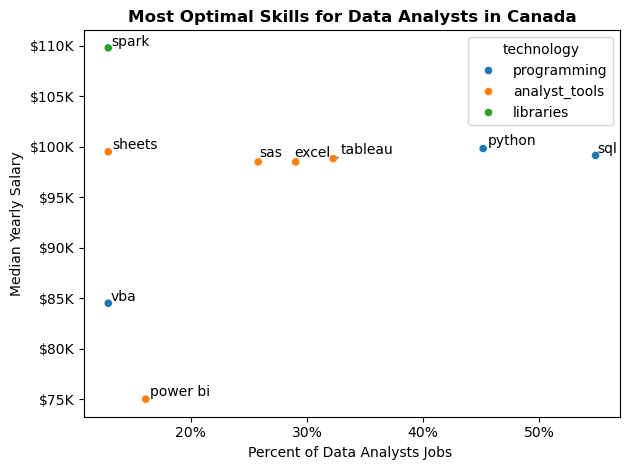

In [116]:
df_ca_plot.reset_index(drop= True)
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter
text = []
sns.scatterplot(df_ca_plot, x = 'job %', y = 'median_salary', hue= 'technology')

for i, x in enumerate(df_ca_plot['job_skills']):
    text.append(plt.text(df_ca_plot['job %'].iloc[i], df_ca_plot['median_salary'].iloc[i], x))

plt.xlabel(f'Percent of {role}s Jobs ')
plt.ylabel('Median Yearly Salary')
plt.title(f'Most Optimal Skills for {role}s in {country}', fontweight ='bold')

adjust_text(text, arrowprops = dict(arrowstyle = '->', color = 'grey'))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals= 0))


plt.tight_layout()
plt.show()